# 1. Setup

### 1.1 Import Dependencies

In [2]:
import cv2
import os
import random
import time
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset/VN-celeb.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

# 2. Preprocess Images

In [6]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/tmp/VN-celeb"

In [7]:
def split_dataset(directory, split=0.8):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.8)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 816
Length of testing list : 204

Test List: {'17': 31, '37': 2, '29': 7, '419': 14, '812': 17, '781': 14, '966': 33, '119': 19, '168': 7, '344': 15, '83': 8, '235': 11, '457': 18, '752': 9, '833': 31, '610': 47, '716': 6, '44': 23, '30': 29, '375': 36, '88': 14, '967': 13, '1012': 42, '836': 16, '495': 6, '55': 8, '220': 38, '664': 19, '144': 26, '195': 3, '343': 11, '608': 11, '728': 32, '685': 40, '190': 28, '720': 79, '680': 75, '594': 53, '646': 15, '322': 6, '866': 38, '70': 14, '304': 5, '319': 8, '105': 12, '704': 3, '801': 13, '80': 9, '356': 29, '266': 18, '978': 10, '905': 10, '112': 4, '290': 8, '537': 26, '350': 16, '502': 48, '265': 37, '249': 4, '625': 32, '639': 32, '486': 10, '484': 28, '1014': 10, '414': 31, '378': 39, '768': 38, '388': 45, '79': 20, '924': 17, '291': 4, '818': 24, '868': 20, '446': 42, '863': 31, '948': 45, '789': 20, '214': 30, '96': 21, '693': 36, '893': 25, '1002': 3, '1007': 21, '192': 9, '862': 15, '348': 18, '98': 18, '

In [8]:
def create_data(directory, folder_list, max_files=10):
    data = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.png")
                positive = (folder, f"{j}.png")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.png")

                path_anchor = os.path.join(ROOT, anchor[0], anchor[1])
                path_positive = os.path.join(ROOT, positive[0], positive[1])
                path_negative = os.path.join(ROOT, negative[0], negative[1])
                data.append((path_anchor, path_positive, path_negative))

    random.shuffle(data)
    return data

In [9]:
train_list = create_data(ROOT, train_list)
test_list  = create_data(ROOT, test_list)

In [10]:
train_list = train_list[:3500]
test_list = test_list[:800]
print("Number of training data:", len(train_list))
print("Number of testing data :", len(test_list))

print("\nExamples of data:")
for i in range(5):
    print(train_list[i])

Number of training data: 3500
Number of testing data : 800

Examples of data:
('/tmp/VN-celeb/926/2.png', '/tmp/VN-celeb/926/3.png', '/tmp/VN-celeb/514/4.png')
('/tmp/VN-celeb/213/3.png', '/tmp/VN-celeb/213/8.png', '/tmp/VN-celeb/321/36.png')
('/tmp/VN-celeb/94/4.png', '/tmp/VN-celeb/94/5.png', '/tmp/VN-celeb/122/2.png')
('/tmp/VN-celeb/511/7.png', '/tmp/VN-celeb/511/8.png', '/tmp/VN-celeb/161/20.png')
('/tmp/VN-celeb/657/5.png', '/tmp/VN-celeb/657/8.png', '/tmp/VN-celeb/1016/37.png')


In [11]:
def Conv2Dataset(list):
  anc, pov, neg = zip(*list)
  anc = tf.constant(anc)
  pov = tf.constant(pov)
  neg = tf.constant(neg)
  anc_dataset = tf.data.Dataset.from_tensor_slices(anc)
  pov_dataset = tf.data.Dataset.from_tensor_slices(pov)
  neg_dataset = tf.data.Dataset.from_tensor_slices(neg)
  dataset = tf.data.Dataset.zip((anc_dataset, pov_dataset, neg_dataset))
  return dataset
train_dataset = Conv2Dataset(train_list)
test_dataset = Conv2Dataset(test_list)

In [12]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (128,128))
    # Scale image to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # Return image
    return img

In [13]:
def preprocess_twin(anc_img, pov_img, neg_img ):
    return(preprocess(anc_img), preprocess(pov_img), preprocess(neg_img))

In [14]:
# Build dataloader pipeline
train_dataset = train_dataset.map(preprocess_twin)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=1000)

test_dataset = test_dataset.map(preprocess_twin)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(buffer_size=1000)


In [15]:
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

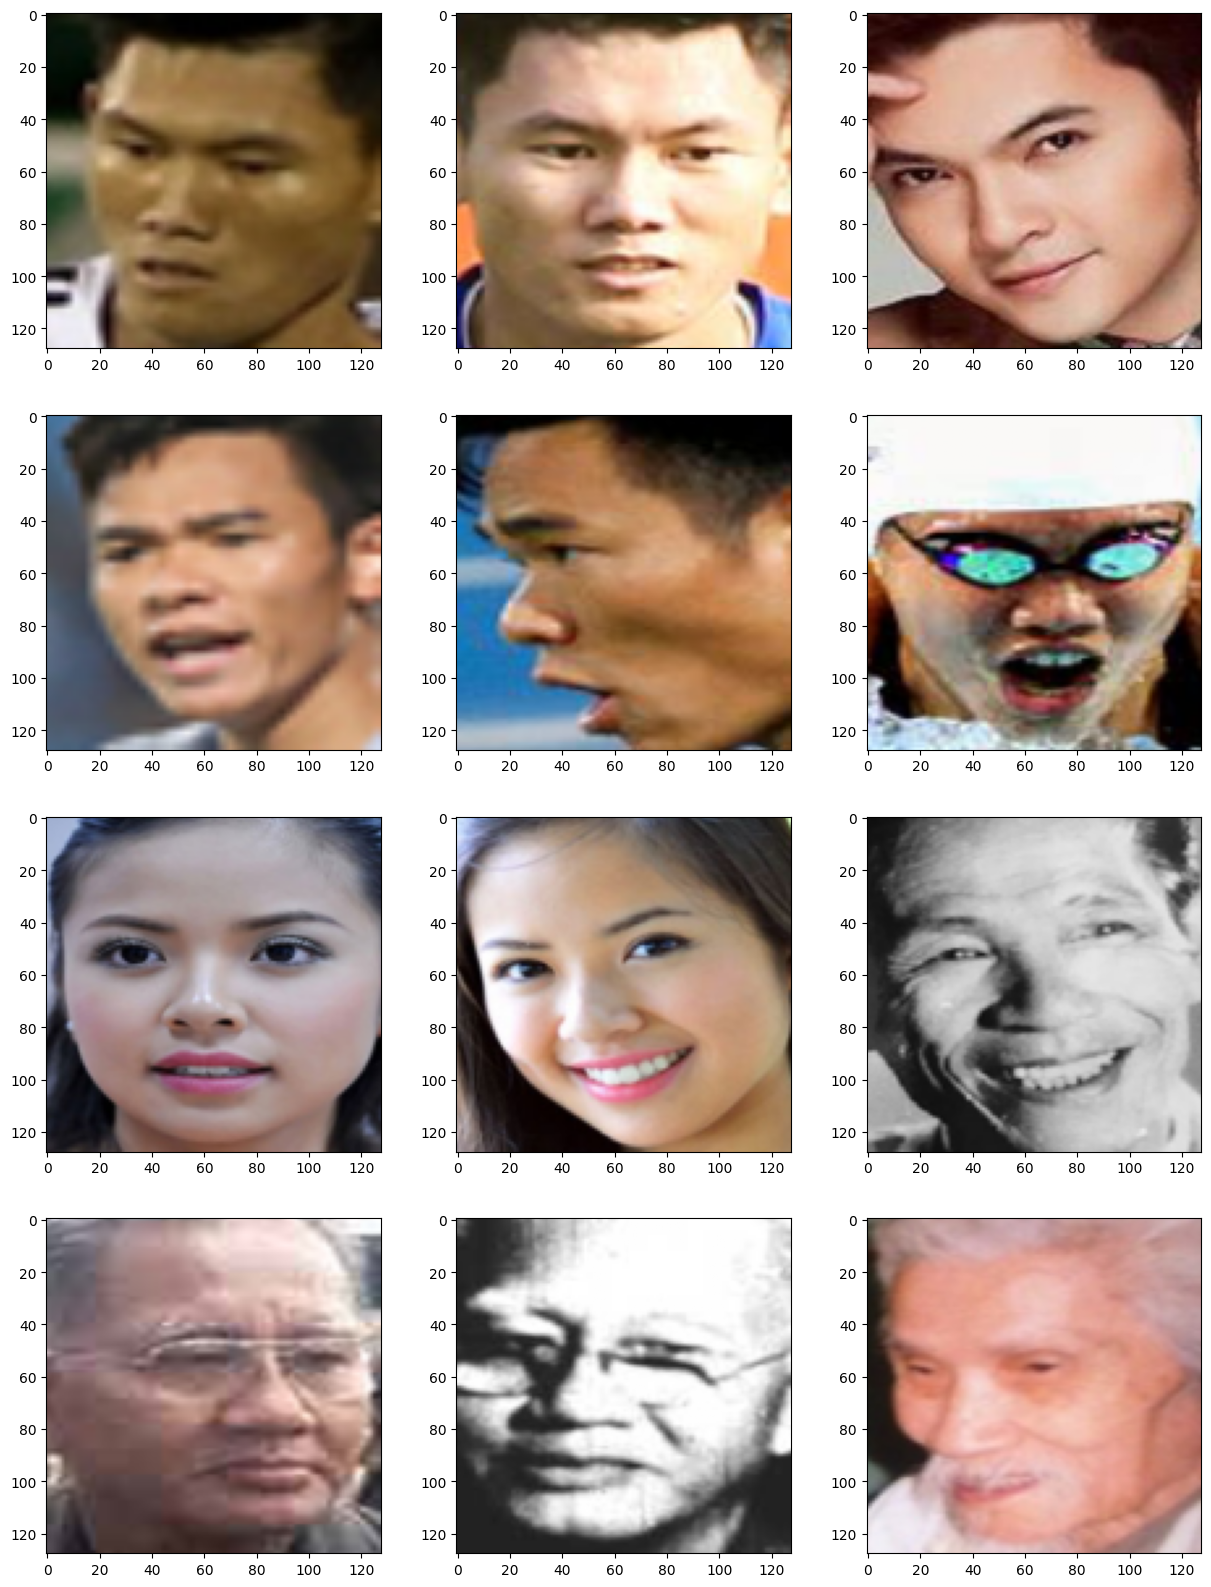

In [16]:
num_plots = 4
f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))
test = train_dataset.as_numpy_iterator()
batch = test.next()
for i in range(num_plots):
  axes[i, 0].imshow(batch[0][i])
  axes[i, 1].imshow(batch[1][i])
  axes[i, 2].imshow(batch[2][i])

# 3. Model Engineering

### 3.1 Build Embedding Layer

In [17]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

83683744/83683744 [==============================] - 3s 0us/step


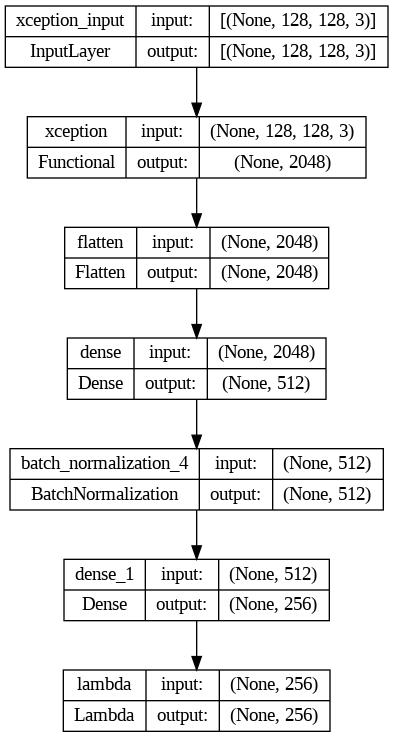

In [18]:
encoder_original = get_encoder(input_shape = (128, 128, 3))
plot_model(encoder_original, show_shapes=True, show_layer_names=True)

### 3.1 Build Model

In [19]:
class DistanceLayer(layers.Layer):
    # A layer to compute ||f(A) - f(P)||^2 and ||f(A) - f(N)||^2
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ||f(A) - f(P)||^2 and ||f(A) - f(N)||^2
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

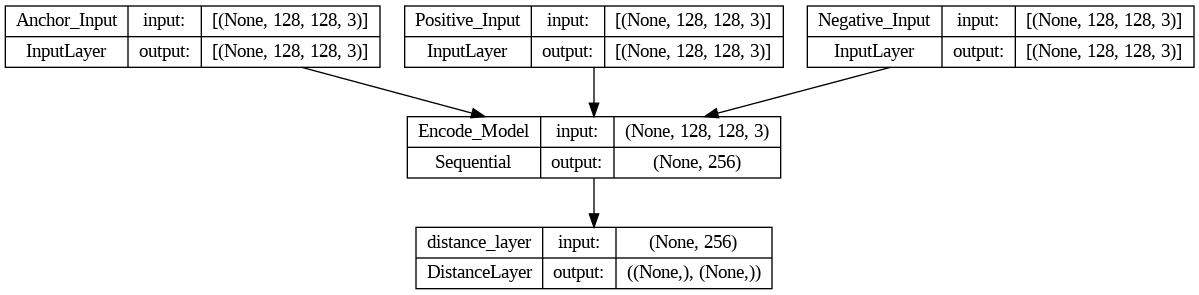

In [20]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [21]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

# 4. Training

### 4.1 Setup Optimizer

In [22]:
siamese_model = SiameseModel(siamese_network)
optimizer = SGD(learning_rate=1e-3, momentum=0.9)
siamese_model.compile(optimizer=optimizer)

### 4.2 Build Evaluate Function

In [23]:
def test_on_triplets():
    pos_scores, neg_scores = [], []

    for idx, batch in enumerate(test_dataset):
        prediction = siamese_model.predict(batch, verbose = 0)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

### 4.3 Training

In [ ]:
save_all = False
epochs = 25
max_acc = 0
train_loss = []
test_metrics = []
for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for idx,data in enumerate(train_dataset):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    # Testing the model on test data
    metric = test_on_triplets()

    test_metrics.append(metric)
    accuracy = metric[0]
    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    print(f"Accuracy on test = {accuracy:.5f}")

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")

# 5. Evaluate Model

In [ ]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()
test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [ ]:
# Print incorrect classification
num_plots = 4
f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))
test_err = test_dataset.as_numpy_iterator()
batch = test_err.next()
prediction = siamese_model.predict(batch, verbose = 0)
pos_scores = prediction[0]
neg_scores = prediction[1]
for i in range(len(pos_scores)):
  if num_plots == -1:
    break
  if pos_scores[i] > neg_scores[i]:
    num_plots -=1
    axes[num_plots, 0].imshow(batch[0][i])
    axes[num_plots, 1].imshow(batch[1][i])
    axes[num_plots, 2].imshow(batch[2][i])


# 6. Using model

In [24]:
checkpoint_path = "/content/drive/MyDrive/Project_1/ModelCheckPoints/siamese_model-final"

In [25]:
siamese_model.load_weights(checkpoint_path)

In [26]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

In [27]:
encoder_trained = extract_encoder(siamese_model)
encoder_trained.save_weights("encoder")
encoder_trained.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 lambda_2 (Lambda)           (None, 256)               0         
                                                      

In [28]:
def classify_images(face_list1, face_list2, encoder, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1, verbose = 0)
    tensor2 = encoder.predict(face_list2, verbose = 0)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [29]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    print(f"\nPrecision score of model: {precision_score(true,pred)}\n")
    print(f"\nRecall score of model: {recall_score(true,pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Positive','Negative']
    names = ['True Positive','False Negative', 'False Positive','True Negative']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


Accuracy of model: 0.660625


Precision score of model: 0.6354056902002108


Recall score of model: 0.75375



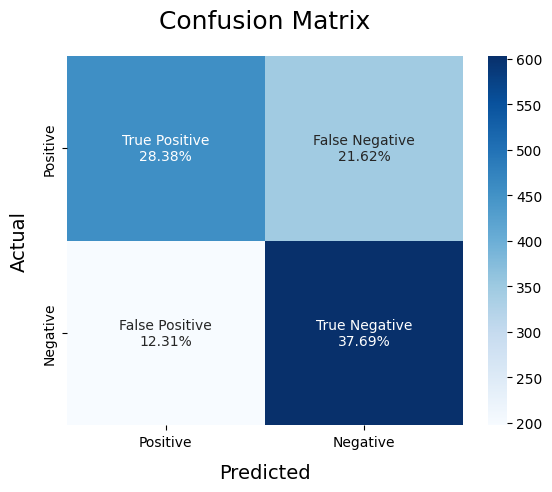

In [30]:
pos_list_ori = np.array([])
neg_list_ori = np.array([])

for idx, data in enumerate(test_dataset):
    a, p, n = data
    pos_list_ori = np.append(pos_list_ori, classify_images(a, p, encoder_original, 0.58))
    neg_list_ori = np.append(neg_list_ori, classify_images(a, n, encoder_original, 0.58))

ModelMetrics(pos_list_ori, neg_list_ori)


Accuracy of model: 0.83375


Precision score of model: 0.875


Recall score of model: 0.77875



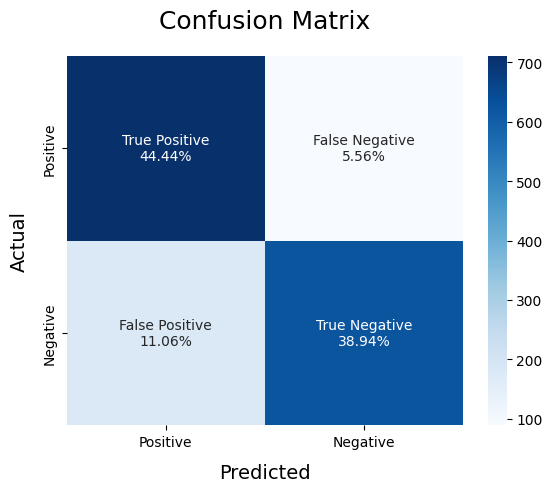

In [31]:
pos_list_trained = np.array([])
neg_list_trained = np.array([])

for idx, data in enumerate(test_dataset):
    a, p, n = data
    pos_list_trained = np.append(pos_list_trained, classify_images(a, p, encoder_trained))
    neg_list_trained = np.append(neg_list_trained, classify_images(a, n, encoder_trained))

ModelMetrics(pos_list_trained, neg_list_trained)